In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.metrics import matthews_corrcoef

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ISC Case study/Data/pre_processed_dataset_balanced.csv')

In [ ]:
df.head()

,age,income_level,fico_score,delinquency_status,number_of_credit_applications,debt_to_income_ratio,payment_methods_high_risk,max_balance,avg_balance_last_12months,number_of_delinquent_accounts,...,multiple_applications_short_time_period,unusual_submission_pattern,applications_submitted_during_odd_hours,watchlist_blacklist_flag,public_records_flag,account_age_days,credit_history_length,location_encoded,occupation_encoded,charge_off_status
0,33,48454,719.0,0,1,1.270638,0,93981.64798,55407.52161,0,...,0,0,0,0,0,1274,566,1,6,0
1,20,52467,404.0,94,8,1.549684,1,30633.91286,11975.53474,3,...,1,1,0,0,0,813,380,1,10,1
2,62,5777,790.0,0,1,2.536890,1,88730.55986,54101.28209,0,...,1,0,0,0,0,1393,3037,3,7,0
3,28,8715,530.0,0,1,1.612346,0,51115.72509,35304.13972,1,...,0,0,1,0,0,948,2887,8,7,0
4,40,23440,624.0,0,1,0.918553,0,66592.17178,42156.14981,0,...,0,0,0,0,0,108,882,9,10,0


In [ ]:
X = df.drop('charge_off_status', axis = 1)
y = df['charge_off_status']

In [ ]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# **Logistic Regression**

In [ ]:

logistic_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200, 500]
}

# Perform grid search for Logistic Regression
logistic_grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=logistic_param_grid,
    scoring='recall',  # Optimize for recall (class 1)
    cv=5,
    verbose=1
)

# Fit grid search on training data
logistic_grid_search.fit(X_train, y_train)

# Best parameters for Logistic Regression
best_logistic_params = logistic_grid_search.best_params_
best_logistic_model = logistic_grid_search.best_estimator_

best_logistic_params


Fitting 5 folds for each of 30 candidates, totalling 150 fits


{'C': 10, 'max_iter': 100, 'solver': 'liblinear'}

In [ ]:
# Train the model on the training data
best_logistic_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lr = best_logistic_model.predict(X_test)
y_pred_proba_lr = best_logistic_model.predict_proba(X_test)[:, 1]

In [ ]:
print("Classification Report:")
cr_lr = classification_report(y_test, y_pred_lr,output_dict=True)
print(classification_report(y_test, y_pred_lr))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

# Calculate ROC-AUC score
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print("ROC-AUC Score:", roc_auc_lr)


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85      1086
           1       0.91      0.74      0.82      1087

    accuracy                           0.83      2173
   macro avg       0.85      0.83      0.83      2173
weighted avg       0.85      0.83      0.83      2173

Confusion Matrix:
[[1009   77]
 [ 286  801]]
ROC-AUC Score: 0.8915417600607208


# **Decision Tree**

In [ ]:
dt = DecisionTreeClassifier(random_state=42)

# Define the hyperparameters grid
param_grid = {
    'criterion': ['gini', 'entropy'],  # Split criteria
    'max_depth': [None, 5, 10, 15, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4, 6],  # Minimum number of samples at a leaf node
    'ccp_alpha': [0.0, 0.01, 0.05, 0.1]  # Complexity parameter for pruning
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1  # Print progress
)

# Fit the grid search model
grid_search.fit(X_train, y_train)

# Best model and parameters
best_model_dt = grid_search.best_estimator_
best_params = grid_search.best_params_


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


In [ ]:
y_pred_dt = best_model_dt.predict(X_test)
y_pred_proba_dt = best_model_dt.predict_proba(X_test)[:, 1]

In [ ]:
cr_dt = classification_report(y_test, y_pred_dt,output_dict=True)
print(classification_report(y_test, y_pred_dt))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

# Calculate ROC-AUC score
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
print("ROC-AUC Score:", roc_auc_dt)


              precision    recall  f1-score   support

           0       0.76      0.94      0.84      1086
           1       0.92      0.70      0.80      1087

    accuracy                           0.82      2173
   macro avg       0.84      0.82      0.82      2173
weighted avg       0.84      0.82      0.82      2173

Confusion Matrix:
[[1017   69]
 [ 324  763]]
ROC-AUC Score: 0.8191980055604406


**Summery of the results**

In [ ]:
def extract_metrics(report):
    return {
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    }

In [ ]:
metrics = [
    {'Model': 'Logistic Regression', **extract_metrics(cr_lr), 'AUC-ROC': roc_auc_lr },
    {'Model': 'Decision Tree', **extract_metrics(cr_dt), 'AUC-ROC': roc_auc_dt}
]

In [ ]:
metrics_df = pd.DataFrame(metrics)
metrics_df

,Model,Precision,Recall,F1-Score,AUC-ROC
0,Logistic Regression,0.845756,0.832950,0.831398,0.891542
1,Decision Tree,0.837765,0.819144,0.816629,0.819198


In [ ]:
metrics_df.columns

Index(['Model', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'], dtype='object')

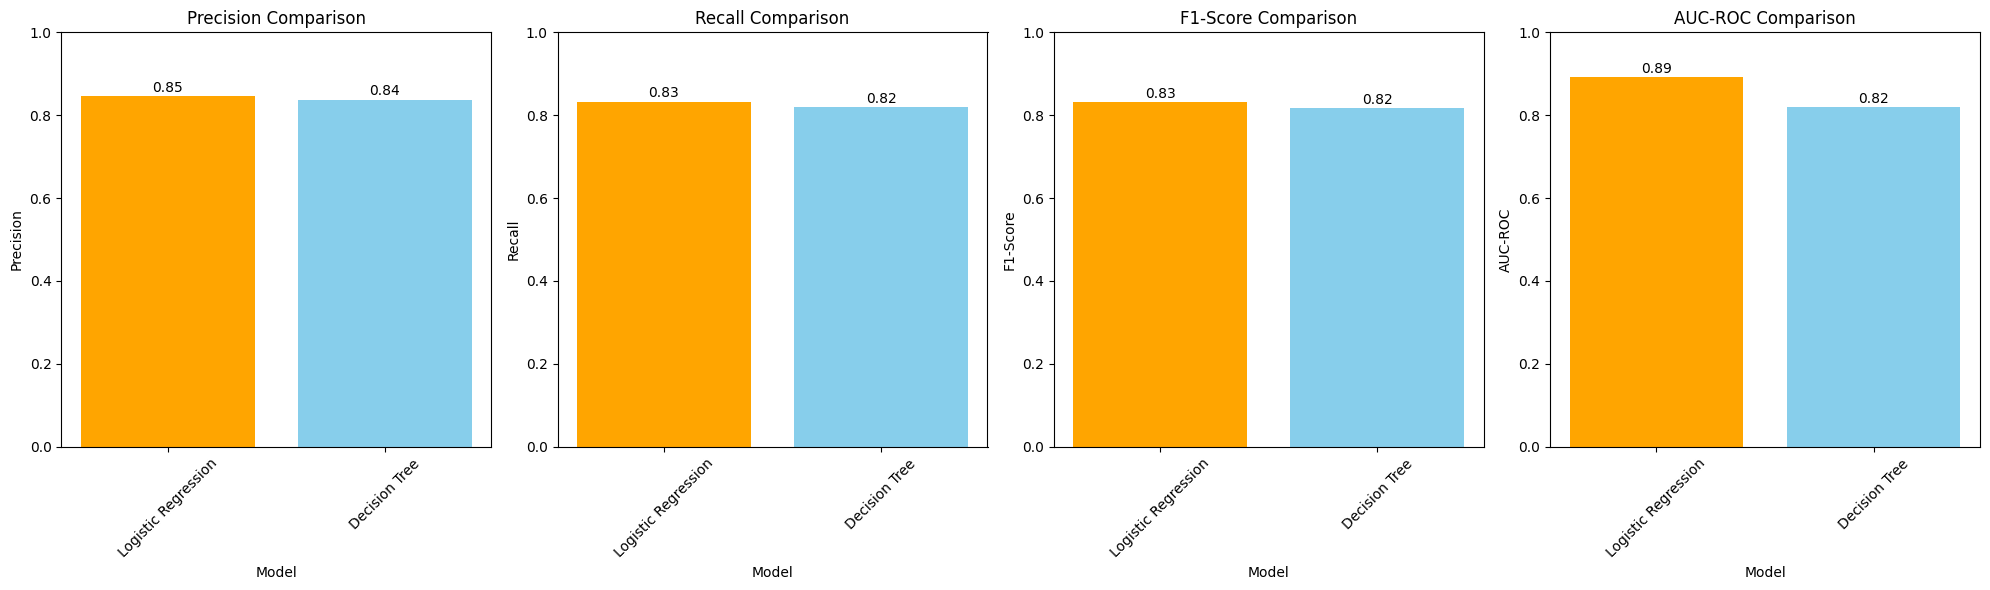

In [ ]:
metrics_to_plot = ['Precision', 'Recall', 'F1-Score', 'AUC-ROC']

# Create a single figure in landscape orientation
fig, axes = plt.subplots(nrows=1, ncols=len(metrics_to_plot), figsize=(20, 6))

for ax, metric in zip(axes, metrics_to_plot):
    # Identify the maximum value
    max_value = metrics_df[metric].max()
    colors = ['skyblue' if value < max_value else 'orange' for value in metrics_df[metric]]

    # Plot bars with conditional coloring
    ax.bar(metrics_df['Model'], metrics_df[metric], color=colors)
    ax.set_title(f'{metric} Comparison')
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)

    # Add text annotation for the max value
    for i, value in enumerate(metrics_df[metric]):
        ax.text(i, value + 0.01, f'{value:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

**Export the model**

In [ ]:
with open('logit_model.pkl', 'wb') as file:
    pickle.dump(best_logistic_model, file)

In [ ]:
with open('dt_model.pkl', 'wb') as file:
    pickle.dump(best_model_dt, file)